In [1]:
print ('Loading dependencies...', end = '')
try:
    import pandas as pd
    from tqdm import tqdm
    import numpy as np
    import os
    from Bio import SeqIO
    from Bio.SeqRecord import SeqRecord
    from Bio.Seq import Seq
    import sys
    from ete3 import NCBITaxa
    ncbi = NCBITaxa()
    print('Successful')
except:
    print('MISSING DEPENDENCIES!')

Loading dependencies...Successful


In [2]:
max_N=0.05
max_per_sp=2

In [3]:
#Sourcing from BOLD https://v3.boldsystems.org/index.php/Public_SearchTerms?query=Magnoliophyta[tax] 
df=pd.read_table('bold_data.txt',encoding = "latin").rename(columns={'species_name':'sci_name',
                'genus_name':'genus','family_name':'family'})
print(df.shape)
print(df.columns)
df[:2]

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (41) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(440117, 46)
Index(['processid', 'sampleid', 'recordID', 'catalognum', 'fieldnum',
       'institution_storing', 'bin_uri', 'phylum_taxID', 'phylum_name',
       'class_taxID', 'class_name', 'order_taxID', 'order_name',
       'family_taxID', 'family', 'subfamily_taxID', 'subfamily_name',
       'genus_taxID', 'genus', 'species_taxID', 'sci_name', 'subspecies_taxID',
       'subspecies_name', 'identification_provided_by', 'voucher_type',
       'tissue_type', 'collectors', 'collectiondate', 'lifestage', 'sex',
       'reproduction', 'extrainfo', 'notes', 'lat', 'lon', 'coord_source',
       'coord_accuracy', 'country', 'province', 'region', 'exactsite',
       'sequenceID', 'markercode', 'genbank_accession', 'nucleotides',
       'Unnamed: 45'],
      dtype='object')


,processid,sampleid,recordID,catalognum,fieldnum,institution_storing,bin_uri,phylum_taxID,phylum_name,class_taxID,...,coord_accuracy,country,province,region,exactsite,sequenceID,markercode,genbank_accession,nucleotides,Unnamed: 45
0,ALM007-11,BC-2011-36007,2096779,,1194-1998-A,"Universite de Montreal, L'Herbier Marie-Victorin",,12,Magnoliophyta,41,...,,Canada,Quebec,,,4168886,rbcLa,,GGTGTTGGATTCAAGGCTGGTGTTAAAGATTATAAATTGACTTATT...,NaN
1,ALM007-11,BC-2011-36007,2096779,,1194-1998-A,"Universite de Montreal, L'Herbier Marie-Victorin",,12,Magnoliophyta,41,...,,Canada,Quebec,,,4179205,matK,,GAAAAATTGGTTCAAATCCTTCGCTATTGGGTGAAAGATCCCTCCT...,NaN


In [4]:
df = df [['processid', 'sampleid', 'recordID', 'sci_name', 'genus', 'family','sequenceID', 
           'markercode', 'nucleotides']]
df[:2]

,processid,sampleid,recordID,sci_name,genus,family,sequenceID,markercode,nucleotides
0,ALM007-11,BC-2011-36007,2096779,,,,4168886,rbcLa,GGTGTTGGATTCAAGGCTGGTGTTAAAGATTATAAATTGACTTATT...
1,ALM007-11,BC-2011-36007,2096779,,,,4179205,matK,GAAAAATTGGTTCAAATCCTTCGCTATTGGGTGAAAGATCCCTCCT...


In [5]:
# Remove samples without species name
print(df.shape)
df = df[~df.sci_name.isna()]
df = df[~ (df.sci_name == ' ')]
print(df.shape)
# Remove samples without sequence
print(df.shape)
df = df[~df.nucleotides.isna()]
df = df[~ (df.nucleotides == ' ')]
print(df.shape)

(440117, 9)
(385516, 9)
(385516, 9)
(376089, 9)


In [17]:
df.groupby('markercode').size().sort_values(ascending=False)

markercode
rbcL               99058
matK               94446
ITS2               92403
ITS                72187
trnH-psbA           8768
trnL-F              2266
ITS1                1673
rpoC1               1196
atpF-atpH           1120
rpoB                 815
psbK-psbI            731
COI-5P               694
ycf1                 137
atpB-rbcL             94
trnK                  72
ETS-1                 63
matR                  61
matK-trnK             48
petD-intron           48
COXIII                47
COII                  46
atp6                  46
matK-like             26
cp-RPS16-intron       25
rbcL-like             19
dtype: int64

In [7]:
df.loc[df.markercode=='rbcLa','markercode']='rbcL'

In [8]:
markers=['matK', 'ITS2', 'rbcL','trnH-psbA']

In [9]:
bold_df=df[df.markercode.isin(markers)]
bold_df['Seq']=bold_df.nucleotides.str.replace('-', '')
bold_df['Len']=bold_df.Seq.str.len()
bold_df = bold_df.rename(columns={'sequenceID':'Locus'})
print(bold_df.shape)
bold_df[:2]

C:\Users\kle10kg\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\kle10kg\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(294675, 11)


,processid,sampleid,recordID,sci_name,genus,family,Locus,markercode,nucleotides,Seq,Len
4,ALM016-11,BC-2011-36016,2096788,Salix chlorolepis,Salix,Salicaceae,4179227,matK,GAAAAATTGGTTCAAATCCTTCGCTATTGGGTGAAAGATCCCTCCT...,GAAAAATTGGTTCAAATCCTTCGCTATTGGGTGAAAGATCCCTCCT...,824
5,ALM016-11,BC-2011-36016,2096788,Salix chlorolepis,Salix,Salicaceae,4168892,rbcL,GGTGTTGGATTCAAGGCTGGTGTTAAAGATTATAAATTGACTTATT...,GGTGTTGGATTCAAGGCTGGTGTTAAAGATTATAAATTGACTTATT...,552


In [10]:
print(bold_df.isna().sum().to_dict())
print(bold_df.nunique().to_dict())

{'processid': 0, 'sampleid': 0, 'recordID': 0, 'sci_name': 0, 'genus': 0, 'family': 0, 'Locus': 0, 'markercode': 0, 'nucleotides': 0, 'Seq': 0, 'Len': 0}
{'processid': 232411, 'sampleid': 232409, 'recordID': 232411, 'sci_name': 77398, 'genus': 11125, 'family': 426, 'Locus': 294675, 'markercode': 4, 'nucleotides': 203236, 'Seq': 199233, 'Len': 1682}


## Filter using WCVP

In [11]:
rm_char='[]()'
for char in rm_char:
    bold_df['sci_name'] = bold_df['sci_name'].str.replace(char,'')

C:\Users\kle10kg\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
print('sending',bold_df.sci_name.nunique(),'species names to WCVP_taxo')
bold_df.groupby('sci_name').head(1).sci_name.to_csv('BOLD_species.csv',index=False)

sending 77398 species names to WCVP_taxo


In [13]:
bold_df.columns

Index(['processid', 'sampleid', 'recordID', 'sci_name', 'genus', 'family',
       'Locus', 'markercode', 'nucleotides', 'Seq', 'Len'],
      dtype='object')

In [14]:
print('running wcvp_taxo',end='...')
print(os.system('python ../../PAFTOL_DB/wcvp_taxo.py ../../PAFTOL_DB/wcvp_v5_jun_2021.txt ' + \
          'BOLD_species.csv' + ' -g -s similarity_genus -d divert_genusOK'))
wcvp = pd.read_csv('BOLD_species' + '_wcvp.csv')
wcvp = wcvp[wcvp.sci_name.notnull()]
print('found',wcvp.sci_name.nunique(),'species in WCVP')
print(bold_df.shape[0],end=' > ')
bold_df = pd.merge(bold_df.rename(columns={'sci_name':'Ini_sci_name'}).drop(columns=['family','genus']),
                   wcvp,how='inner',on='Ini_sci_name')
print(bold_df.shape[0])
print('f:',bold_df.family.nunique(),'g:',bold_df.genus.nunique(),'s:',bold_df.sci_name.nunique())

running wcvp_taxo...found 65026 species in WCVP
294675 > 279108
f: 412 g: 10137 s: 65026


In [15]:
rm_char='[]()×'
for char in rm_char:
    bold_df['sci_name'] = bold_df['sci_name'].str.replace(char,'')

C:\Users\kle10kg\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


## Save to fasta

In [16]:
def writefasta(rec_df, marker):
    rec_fasta=[]
    for idx, row in rec_df.iterrows():
        record = SeqRecord(Seq(row.Seq))
        record.id = str(row.Locus)
        record.description = ';' \
        + 'f=' + row.family + ',g=' + row.genus + ',s=' + row.sci_name + ',ini_s=' + row.Ini_sci_name + ';'
        rec_fasta.append(record)
#     return rec_fasta
    SeqIO.write(rec_fasta,'BOLD_' + marker + '.fasta',format='fasta')

f: 408 g: 7660 s: 31953
{0.01: 425.0, 0.05: 508.0, 0.1: 529.0, 0.5: 553.0, 0.9: 1386.0, 0.95: 1389.0, 0.99: 1449.0}
94258 > 44992 > 20935
{0.01: 522.0, 0.05: 527.0, 0.1: 538.0, 0.5: 552.0, 0.9: 553.0, 0.95: 567.0, 0.99: 576.0}
f: 300 g: 3660 s: 13528


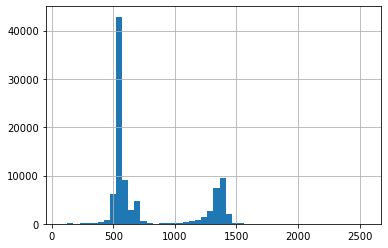

In [30]:
marker = 'rbcLa'
bold_marker=bold_df[bold_df.markercode=='rbcL']
print('f:',bold_marker.family.nunique(),'g:',bold_marker.genus.nunique(),'s:',bold_marker.sci_name.nunique())
print(bold_marker.Len.quantile([0.01, 0.05, .1, .5, 0.9, 0.95, 0.99]).to_dict())
bold_marker.Len.hist(bins=50);
print(bold_marker.shape[0],end=' > ')
bold_marker = bold_marker[(bold_marker.Len>=520) & (bold_marker.Len<=580)]
print(bold_marker.shape[0],end=' > ')
bold_marker = bold_marker.sort_values('family').groupby('sci_name').head(2)
print(bold_marker.shape[0])
print(bold_marker.Len.quantile([0.01, 0.05, .1, .5, 0.9, 0.95, 0.99]).to_dict())
writefasta(bold_marker,marker)
bold_marker[['Locus','Len',
          'sci_name', 'kew_id','family', 'genus', 'species', 'infraspecies', 'Duplicates',
          'Ini_sci_name']].to_csv('BOLD_' + marker + '_TAXO.csv',index=False)
print('f:',bold_marker.family.nunique(),'g:',bold_marker.genus.nunique(),'s:',bold_marker.sci_name.nunique())

f: 408 g: 7660 s: 31953
{0.01: 425.0, 0.05: 508.0, 0.1: 529.0, 0.5: 553.0, 0.9: 1386.0, 0.95: 1389.0, 0.99: 1449.0}
94258 > 23572 > 20396
{0.01: 1212.0, 0.05: 1251.0, 0.1: 1281.0, 0.5: 1362.0, 0.9: 1389.0, 0.95: 1428.0, 0.99: 1458.0}
f: 401 g: 6113 s: 16725


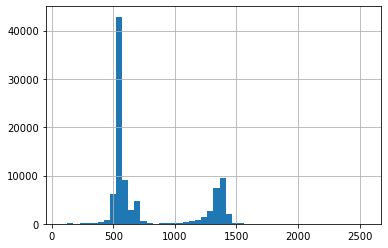

In [35]:
marker = 'rbcL'
bold_marker=bold_df[bold_df.markercode==marker]
print('f:',bold_marker.family.nunique(),'g:',bold_marker.genus.nunique(),'s:',bold_marker.sci_name.nunique())
print(bold_marker.Len.quantile([0.01, 0.05, .1, .5, 0.9, 0.95, 0.99]).to_dict())
bold_marker.Len.hist(bins=50);
print(bold_marker.shape[0],end=' > ')
bold_marker = bold_marker[(bold_marker.Len>=1200) & (bold_marker.Len<=1500)]
print(bold_marker.shape[0],end=' > ')
bold_marker = bold_marker.sort_values('family').groupby('sci_name').head(2)
print(bold_marker.shape[0])
print(bold_marker.Len.quantile([0.01, 0.05, .1, .5, 0.9, 0.95, 0.99]).to_dict())
writefasta(bold_marker,marker)
bold_marker[['Locus','Len',
          'sci_name', 'kew_id','family', 'genus', 'species', 'infraspecies', 'Duplicates',
          'Ini_sci_name']].to_csv('BOLD_' + marker + '_TAXO.csv',index=False)
print('f:',bold_marker.family.nunique(),'g:',bold_marker.genus.nunique(),'s:',bold_marker.sci_name.nunique())

f: 396 g: 7689 s: 37600
{0.01: 330.0, 0.05: 510.0, 0.1: 631.0, 0.5: 817.0, 0.9: 1530.0, 0.95: 1544.0, 0.99: 1566.0}
89752 > 52724 > 28474
{0.01: 514.0, 0.05: 578.0, 0.1: 639.0, 0.5: 776.0, 0.9: 860.0, 0.95: 912.0, 0.99: 985.0}
f: 331 g: 4393 s: 19697


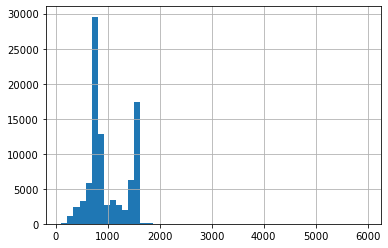

In [37]:
marker = 'matK'
bold_marker=bold_df[bold_df.markercode==marker]
print('f:',bold_marker.family.nunique(),'g:',bold_marker.genus.nunique(),'s:',bold_marker.sci_name.nunique())
print(bold_marker.Len.quantile([0.01, 0.05, .1, .5, 0.9, 0.95, 0.99]).to_dict())
bold_marker.Len.hist(bins=50);
print(bold_marker.shape[0],end=' > ')
bold_marker = bold_marker[(bold_marker.Len>=500) & (bold_marker.Len<=1000)]
print(bold_marker.shape[0],end=' > ')
bold_marker = bold_marker.sort_values('family').groupby('sci_name').head(2)
print(bold_marker.shape[0])
print(bold_marker.Len.quantile([0.01, 0.05, .1, .5, 0.9, 0.95, 0.99]).to_dict())
writefasta(bold_marker,marker)
bold_marker[['Locus','Len',
          'sci_name', 'kew_id','family', 'genus', 'species', 'infraspecies', 'Duplicates',
          'Ini_sci_name']].to_csv('BOLD_' + marker + '_TAXO.csv',index=False)
print('f:',bold_marker.family.nunique(),'g:',bold_marker.genus.nunique(),'s:',bold_marker.sci_name.nunique())

f: 267 g: 5735 s: 36051
{0.01: 166.0, 0.05: 191.0, 0.1: 203.0, 0.5: 229.0, 0.9: 351.0, 0.95: 420.0, 0.99: 460.0}
86728 > 63489 > 40389
{0.01: 176.0, 0.05: 191.0, 0.1: 201.0, 0.5: 221.0, 0.9: 250.0, 0.95: 260.0, 0.99: 276.0}
f: 230 g: 5077 s: 30811


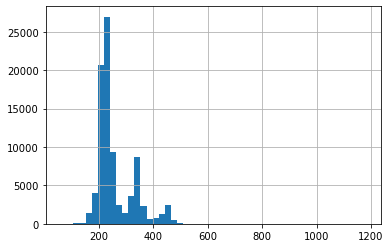

In [38]:
marker = 'ITS2'
bold_marker=bold_df[bold_df.markercode==marker]
print('f:',bold_marker.family.nunique(),'g:',bold_marker.genus.nunique(),'s:',bold_marker.sci_name.nunique())
print(bold_marker.Len.quantile([0.01, 0.05, .1, .5, 0.9, 0.95, 0.99]).to_dict())
bold_marker.Len.hist(bins=50);
print(bold_marker.shape[0],end=' > ')
bold_marker = bold_marker[(bold_marker.Len>=170) & (bold_marker.Len<=280)]
print(bold_marker.shape[0],end=' > ')
bold_marker = bold_marker.sort_values('family').groupby('sci_name').head(2)
print(bold_marker.shape[0])
print(bold_marker.Len.quantile([0.01, 0.05, .1, .5, 0.9, 0.95, 0.99]).to_dict())
writefasta(bold_marker,marker)
bold_marker[['Locus','Len',
          'sci_name', 'kew_id','family', 'genus', 'species', 'infraspecies', 'Duplicates',
          'Ini_sci_name']].to_csv('BOLD_' + marker + '_TAXO.csv',index=False)
print('f:',bold_marker.family.nunique(),'g:',bold_marker.genus.nunique(),'s:',bold_marker.sci_name.nunique())

f: 191 g: 1176 s: 3205
{0.01: 196.0, 0.05: 236.0, 0.1: 269.0, 0.5: 431.0, 0.9: 618.0, 0.95: 640.0, 0.99: 822.0}
8370 > 7942 > 4767
{0.01: 217.0, 0.05: 241.3, 0.1: 274.0, 0.5: 428.0, 0.9: 600.4000000000005, 0.95: 620.0, 0.99: 641.0}
f: 188 g: 1135 s: 3016


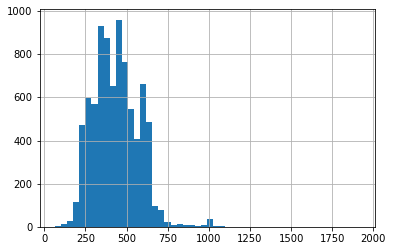

In [39]:
marker = 'trnH-psbA'
bold_marker=bold_df[bold_df.markercode==marker]
print('f:',bold_marker.family.nunique(),'g:',bold_marker.genus.nunique(),'s:',bold_marker.sci_name.nunique())
print(bold_marker.Len.quantile([0.01, 0.05, .1, .5, 0.9, 0.95, 0.99]).to_dict())
bold_marker.Len.hist(bins=50);
print(bold_marker.shape[0],end=' > ')
bold_marker = bold_marker[(bold_marker.Len>=200) & (bold_marker.Len<=650)]
print(bold_marker.shape[0],end=' > ')
bold_marker = bold_marker.sort_values('family').groupby('sci_name').head(2)
print(bold_marker.shape[0])
print(bold_marker.Len.quantile([0.01, 0.05, .1, .5, 0.9, 0.95, 0.99]).to_dict())
writefasta(bold_marker,marker)
bold_marker[['Locus','Len',
          'sci_name', 'kew_id','family', 'genus', 'species', 'infraspecies', 'Duplicates',
          'Ini_sci_name']].to_csv('BOLD_' + marker + '_TAXO.csv',index=False)
print('f:',bold_marker.family.nunique(),'g:',bold_marker.genus.nunique(),'s:',bold_marker.sci_name.nunique())